## Finding Lane Lines

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read images

shape:  (540, 960, 3)
type:  uint8


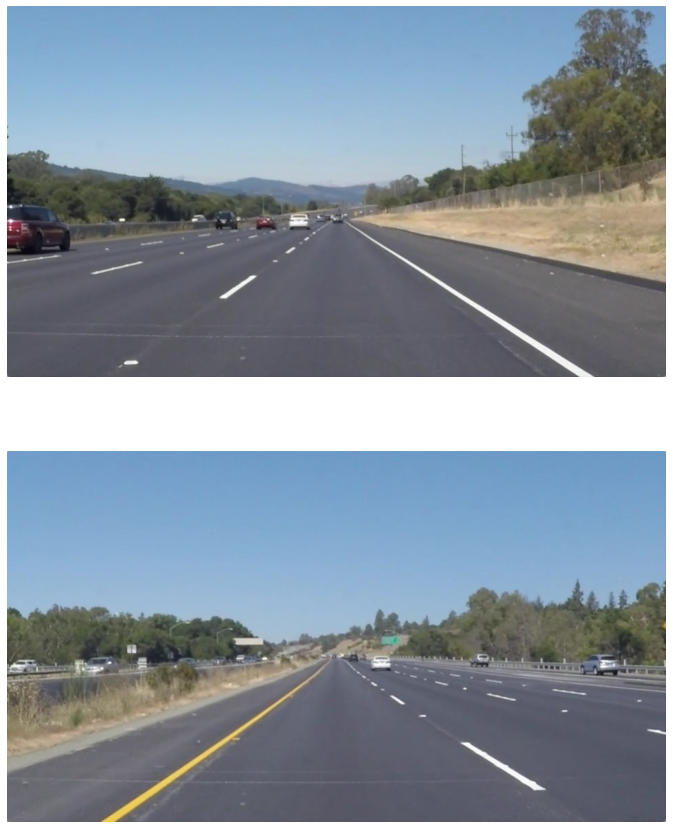

In [54]:
img1 = cv2.imread('solidWhiteRight.jpg')
img2 = cv2.imread('solidYellowLeft.jpg')

print('shape: ', img1.shape)
print('type: ', img1.dtype)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### 도로 라인 지정

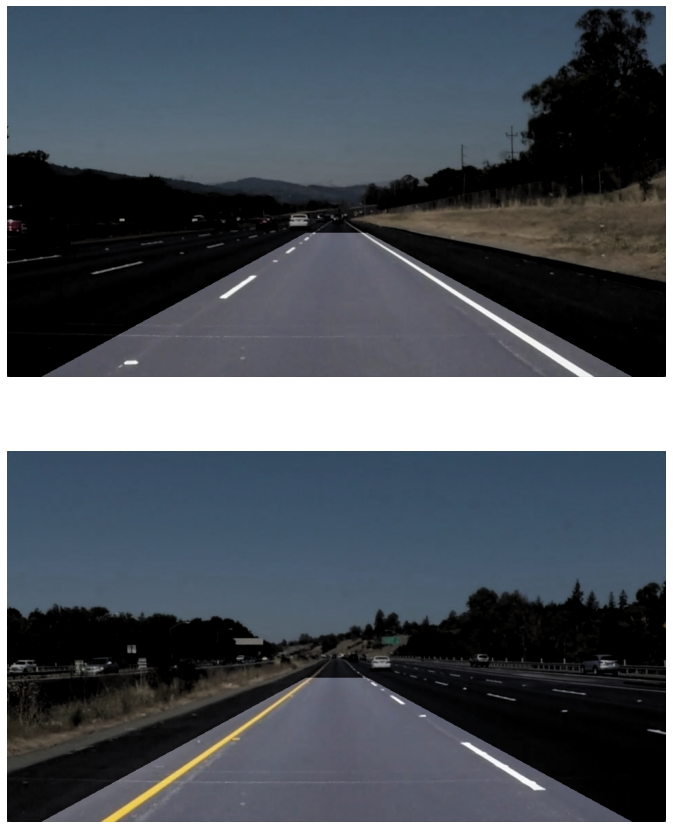

In [55]:
listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg']

plt.figure(figsize=(15,15))

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)
    height, width = img.shape[:2]
    # 직접 사다리꼴 도로 라인 지정
    vertices = np.array([[(50, height), (width/2 - 45, height/2 + 60),
                          (width/2 + 45, height/2 + 60), (width - 50, height)]], dtype='int')
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    mask = np.zeros(img.shape[:2])
    cv2.fillPoly(mask, vertices, 255)

    inv_mask = cv2.bitwise_not(mask.astype('uint8'))
    v = cv2.addWeighted(v, 1.0, inv_mask, -0.4, 0.0)

    roi = cv2.merge([h, s, v])
    roi = cv2.cvtColor(roi, cv2.COLOR_HSV2RGB)

    plt.subplot(2, 1 , i+1)
    plt.imshow(roi)
    plt.axis('off')
plt.show()

### 과제


In [56]:
def region_of_interest(img, vertices):
    '''
    영상에서 관심 영역만 남김

    Parameters
    ----------
    img: array
        적용할 타겟 영상
    vertices: list of points
        관심 영역의 좌표점들이 저장된 리스트
    '''
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)

    return cv2.bitwise_and(img, mask)

def full_pipeline(img):
    '''
    To do
    차선 검출을 위한 전체 파이프라인 코드
    '''
    result = np.copy(img)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(result, (x1, y1), (x2, y2), color=(0,0,255), thickness=5)
    return result


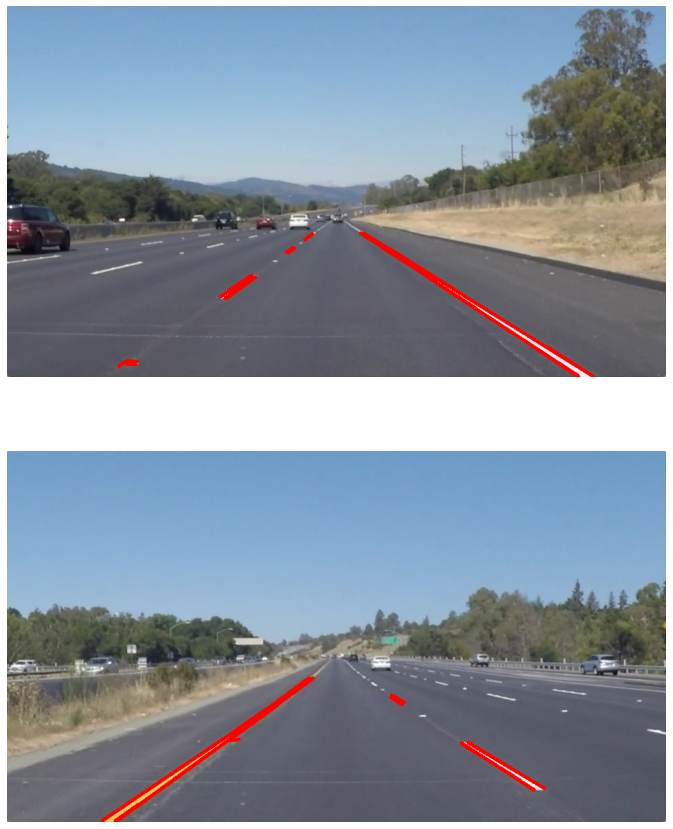

In [57]:
def full_pipeline(img):
    height, width = img.shape[:2]
    # 직접 사다리꼴 도로 라인 지정
    vertices = np.array([[(50, height), (width/2 - 45, height/2 + 60),
                          (width/2 + 45, height/2 + 60), (width - 50, height)]], dtype='int')
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
    edge_img = cv2.Canny(blur_img, 70, 180)

    roi_img = region_of_interest(edge_img, vertices)
    lines = cv2.HoughLinesP(roi_img, rho=1,
                            theta=np.pi/180,
                            threshold=10,
                            minLineLength=10,
                            maxLineGap=5)
    result = np.copy(img)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(result, (x1, y1), (x2, y2), color=(0,0,255), thickness=3)

    return result


listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg']

plt.figure(figsize=(15,15))

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)
    result = full_pipeline(img)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 1 , i+1)
    plt.imshow(result)
    plt.axis('off')
plt.show()

### ※ Challenging case

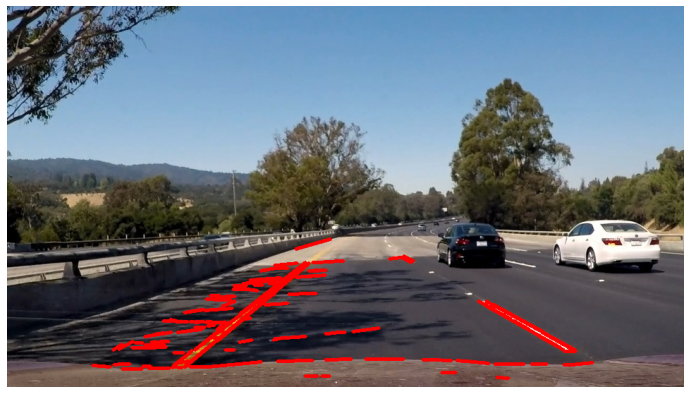

In [59]:
img = cv2.imread('challenge.jpg')

result = full_pipeline(img)

plt.figure(figsize=(15,7))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

def improved_pipeline(img):
    '''
    To do
    '''

    return result

In [69]:
class Line:
    '''
    하나의 직선에 대한 기울기와 y절편 정보를 갖는 클래스
    '''
    def __init__(self, x1, y1, x2, y2):
        self.x1 = float(x1)
        self.y1 = float(y1)
        self.x2 = float(x2)
        self.y2 = float(y2)

        self.slope = self.compute_slope()
        self.bias = self.compute_bias()

    def compute_slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1 + 1e-7)  # 1e-7은 분모가 0이 되는 것을 방지하기 위함

    def compute_bias(self):
        return self.y1 - self.slope * self.x1

    def get_coords(self):
        return np.array([self.x1, self.y1, self.x2, self.y2])

    def set_coords(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def draw(self, img, color=(0,0,255), thickness=5):
        cv2.line(img, (int(self.x1), int(self.y1)), (int(self.x2), int(self.y2)), color, thickness)

In [70]:
def get_lanes(lines, y_end):
    '''
    후보 직선 리스트를 입력으로 받아 차선에 해당하는 두 직선(좌측, 우측)을 계산함

    Parameters
    ----------
    lines: list of Line instances
        후보 Line 인스턴스들의 리스트
    y_end: int
        차선 직선의 끝점을 계산하기 위한 영상의 높이 정보
    '''
    ## 음수 기울기(좌측 차선)를 갖는 직선들과 양수 기울기(우측 차선)를 갖는 직선들로 분류
    neg_lines = [line for line in lines if line.slope < -0.3]  # 수평에 가까운 직선을 제거하기 위한 기울기 임계값 사용
    pos_lines = [line for line in lines if 0.3 < line.slope]

    ## 후보 직선들 중 중앙값에 해당하는 직선을 대표 직선으로 선택
    left_line_bias = np.median([line.bias for line in neg_lines]).astype('int32')
    left_line_slope = np.median([line.slope for line in neg_lines])

    right_line_bias = np.median([l.bias for l in pos_lines]).astype('int32')
    right_line_slope = np.median([l.slope for l in pos_lines])

    ## 소실점(vanishing point)을 기반으로 차선의 시작점 설정
    ## 두 직선(y = a1x + b1, y = a2x + b2)의 교점을 소실점으로 고려하여 계산
    vanishing_y = int(left_line_slope*right_line_bias - right_line_slope*left_line_bias) /(left_line_slope-right_line_slope)
    offset = int(y_end*0.05)          # 임의의 오프셋 설정
    y_init = vanishing_y + offset

    ## 각 차선의 시작점과 끝점 좌표 계산
    x1, y1 = 0, left_line_bias
    x2, y2 = int((y_init - left_line_bias) / left_line_slope), y_init
    lLane = Line(x1, y1, x2, y2)

    x1, y1 = int((y_init - right_line_bias) / right_line_slope), y_init
    x2, y2 = int((y_end - right_line_bias) / right_line_slope), y_end
    rLane = Line(x1, y1, x2, y2)

    return lLane, rLane

In [71]:
def improved_pipeline(img):
    height, width = img.shape[:2]

    vertices = np.array([[(50, height), (width/2 - 45, height/2 + 60),
                          (width/2 + 45, height/2 + 60), (width - 50, height)]], dtype='int')
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
    edge_img = cv2.Canny(blur_img, 70, 180)

    roi_img = region_of_interest(edge_img, vertices)
    lines = cv2.HoughLinesP(roi_img, rho=1,
                            theta=np.pi/180,
                            threshold=10,
                            minLineLength=10,
                            maxLineGap=5)
    candidate_lines = [Line(*line[0]) for line in lines]
    lLane, rLane = get_lanes(candidate_lines, y_end=height)
    line_img = np.zeros_like(img)
    lLane.draw(line_img)
    rLane.draw(line_img)
    result = cv2.addWeighted(img, 1.0, line_img, 1.0, 0.0)

    return result

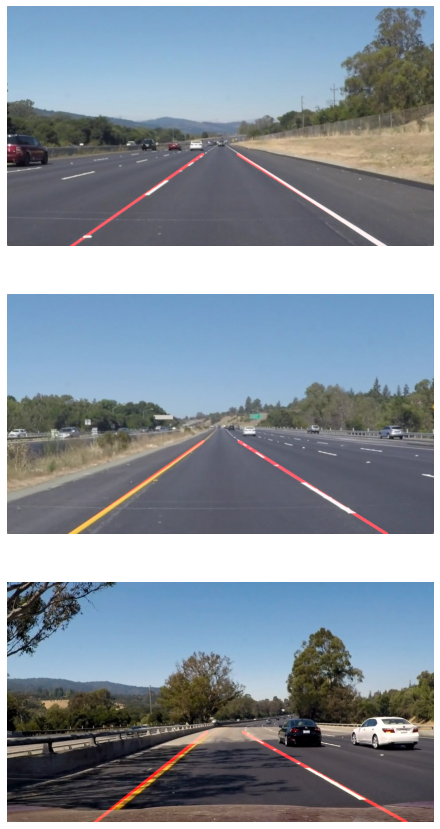

In [72]:
listOfFiles = ['solidWhiteRight.jpg', 'solidYellowLeft.jpg', 'challenge.jpg']

plt.figure(figsize=(15,15))

for i, file in enumerate(listOfFiles):
    img = cv2.imread(file)

    result = improved_pipeline(img)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 1 , i+1)
    plt.imshow(result)
    plt.axis('off')
plt.show()